In [1]:
import numpy as np
import numpy.ma as ma
import random
import matplotlib.pyplot as plt
import seaborn as sns
from nim_env import NimEnv, OptimalPlayer
import pandas as pd

# Q-learning

In [2]:
class NimQlearningAgent:
    #Q learning agent for Nim with epsilon-greedy policy
    def __init__(self, alpha=0.1, gamma=0.99, epsilon=0.1, player=0, Q=None):
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.player = player #  0 or 1
        a = np.zeros((8, 8, 8, 3, 7))
        if Q is not None:
            self.Q = Q
        else:
            for s1 in range(8):
                for s2 in range(8):
                    for s3 in range(8):
                        for a1 in range(3):
                            for a2 in range(7):
                                if a1 == 0:
                                    if a2 >= s1:
                                        a[s1, s2, s3, a1, a2] = np.NaN
                                elif a1 == 1:
                                    if a2 >= s2:
                                        a[s1, s2, s3, a1, a2] = np.NaN
                                else:
                                    if a2 >= s3:
                                        a[s1, s2, s3, a1, a2] = np.NaN
            self.Q = ma.masked_invalid(a)
    
    def copy(self):
        return NimQlearningAgent(alpha=self.alpha, gamma=self.gamma, epsilon=self.epsilon, player=self.player, Q=self.Q)
    
    def randomMove(self, heaps):
        # the indexes of the heaps available are given by
        heaps_avail = [i for i in range(len(heaps)) if heaps[i] > 0]
        chosen_heap = random.choice(heaps_avail)
        n_obj = random.choice(range(1, heaps[chosen_heap] + 1))
        move = [chosen_heap + 1, n_obj]
        return move
        
    def act(self, heaps):
        if random.random() < self.epsilon:
            return self.randomMove(heaps)
        else:
            move = np.unravel_index(np.argmax(self.Q[heaps[0], heaps[1], heaps[2], :, :]), self.Q[heaps[0], heaps[1], heaps[2], :, :].shape)
            return [move[0] + 1, move[1] + 1]
        
    def update(self, oldHeaps, move, newHeaps, reward):
        if ((oldHeaps is not None) and (move is not None) and (newHeaps is not None)):
            oldQ = self.Q[oldHeaps[0], oldHeaps[1], oldHeaps[2], move[0] - 1, move[1] -1]
            if newHeaps != [0,0,0]:
                self.Q[oldHeaps[0], oldHeaps[1], oldHeaps[2], move[0] -1, move[1]-1] = oldQ + self.alpha *(reward + self.gamma * np.max(self.Q[newHeaps[0], newHeaps[1], newHeaps[2], :, :]) - oldQ)
            else:
                self.Q[oldHeaps[0], oldHeaps[1], oldHeaps[2], move[0] -1, move[1]-1] = oldQ + self.alpha *(reward - oldQ)


In [3]:
def get_epsilonN(gameNumber, exploreGames, epsilonMin=0.1, epsilonMax=0.8):
    return max(epsilonMin, epsilonMax * (1 - gameNumber/exploreGames))

def playGames(env, player1, player2, numGames=20000):
    reward_sum = 0
    games_won = 0
    avg_rewards = []
    for i in range(numGames):
        env.reset()
        lastActionState = None
        lastAction = None
        while not env.end:
            heaps, _, __ = env.observe()
            if env.current_player == player2.player:
                move = player2.act(heaps)
                newHeaps, end, winner = env.step(move)
            else:
                if (lastActionState is not None and lastAction is not None):
                    reward = env.reward(player=player1.player)
                    player1.update(lastActionState, lastAction, newHeaps, reward)
                lastActionState = heaps.copy()
                move = player1.act(heaps)
                lastAction = move
                newHeaps, end, winner = env.step(move)

            if end:
                reward = env.reward(player=player1.player)
                player1.update(lastActionState, lastAction, newHeaps, reward)
                reward_sum += reward
                if reward > 0:
                    games_won += 1
                if ( (i+1) % 250 == 0):
                    avg_rewards.append(reward_sum / 250)
                    reward_sum = 0
                break

        player1.player = 1 - player1.player
        player2.player = 1 - player2.player
    
    print(f"Winrate: {games_won/numGames}")
    return avg_rewards

def playGamesDecreasingExploration(env, player1, player2, exploGames, numGames=20000):
    reward_sum = 0
    games_won = 0
    avg_rewards = []
    M_opts = []
    M_rands = []
    for i in range(numGames):
        player1.epsilon = get_epsilonN(i+1, exploGames)
        env.reset()
        lastActionState = None
        lastAction = None
        while not env.end:
            heaps, _, __ = env.observe()
            if env.current_player == player2.player:
                move = player2.act(heaps)
                newHeaps, end, winner = env.step(move)
            else:
                if (lastActionState is not None and lastAction is not None):
                    reward = env.reward(player=player1.player)
                    player1.update(lastActionState, lastAction, newHeaps, reward)
                lastActionState = heaps.copy()
                move = player1.act(heaps)
                lastAction = move
                newHeaps, end, winner = env.step(move)

            if end:
                reward = env.reward(player=player1.player)
                player1.update(lastActionState, lastAction, newHeaps, reward)
                reward_sum += reward
                if reward > 0:
                    games_won += 1
                if ( (i+1) % 250 == 0):
                    avg_rewards.append(reward_sum / 250)
                    reward_sum = 0
                    M_opt = calc_M(env, player1, 0)
                    M_rand = calc_M(env, player1, 1)
                    M_opts.append(M_opt)
                    M_rands.append(M_rand)
                break

        player1.player = 1 - player1.player
        player2.player = 1 - player2.player
    
    print(f"Winrate: {games_won/numGames}")
    return avg_rewards, M_opts, M_rands

def calc_M(env, player, epsilon, N=500):
    player_test = player.copy()
    player_test.player = 0
    player_test.epsilon = 0
    player_opt = OptimalPlayer(epsilon=epsilon, player=1)
    games_won = 0
    for i in range(N):
        env.reset()
        while not env.end:
            heaps, _, __ = env.observe()
            if env.current_player == player_opt.player:
                move = player_opt.act(heaps)
                newHeaps, end, winner = env.step(move)
            else:
                move = player_test.act(heaps)
                newHeaps, end, winner = env.step(move)
            if end:
                reward = env.reward(player=player_test.player)
                if reward > 0:
                    games_won += 1
                break

        player_opt.player = 1 - player_opt.player
        player_test.player = 1 - player_test.player
    
    return (2* games_won - N) / N

In [4]:
env = NimEnv(seed = 10)

### vs. Opt(0.5) with fixed epsilon=0.1

Winrate: 0.70275


<AxesSubplot:>

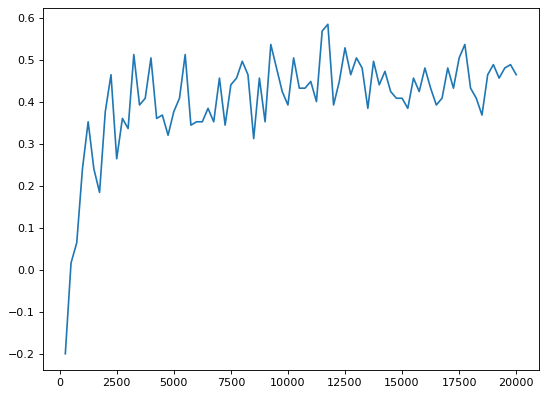

In [5]:
# Question 1
player_Q = NimQlearningAgent(player=0, epsilon=0.1)
player_opt = OptimalPlayer(epsilon=0.5, player=1)
avg_rewards = playGames(env, player_Q, player_opt)
plt.figure(figsize=(10, 6), dpi=80)
ax = sns.lineplot(x=list(range(250, 20001, 250)), y=avg_rewards)
ax.set(ylabel="Average reward", xlabel="Number of games")
plt.show()

### vs. Opt(0.5) with decreasing exploration

In [6]:
avg_rewardsDE = pd.DataFrame(index=list(range(250, 20001, 250))).rename_axis("Number of games")
avg_rewardsDE = avg_rewardsDE.rename_axis("n*", axis=1)

M_optsDE = pd.DataFrame(index=list(range(250, 20001, 250))).rename_axis("Number of games")
M_optsDE = M_optsDE.rename_axis("n*", axis=1)

M_randsDE = pd.DataFrame(index=list(range(250, 20001, 250))).rename_axis("Number of games")
M_randsDE = M_randsDE.rename_axis("n*", axis=1)

player_Q_DE = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 1)
avg_rewardsDE["1"] = avg_rewards
M_optsDE["1"] = M_opts
M_randsDE["1"] = M_rands

# player_Q_DE = NimQlearningAgent(player=0)
# avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 1000)
# avg_rewardsDE["1000"] = avg_rewards
# M_optsDE["1000"] = M_opts
# M_randsDE["1000"] = M_rands

player_Q_DE = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 5000)
avg_rewardsDE["5000"] = avg_rewards
M_optsDE["5000"] = M_opts
M_randsDE["5000"] = M_rands

player_Q_DE = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 10000)
avg_rewardsDE["10000"] = avg_rewards
M_optsDE["10000"] = M_opts
M_randsDE["10000"] = M_rands

player_Q_DE = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 20000)
avg_rewardsDE["20000"] = avg_rewards
M_optsDE["20000"] = M_opts
M_randsDE["20000"] = M_rands

player_Q_DE = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 40000)
avg_rewardsDE["40000"] = avg_rewards
M_optsDE["40000"] = M_opts
M_randsDE["40000"] = M_rands

Winrate: 0.70925
Winrate: 0.66735
Winrate: 0.6257
Winrate: 0.54015
Winrate: 0.42605


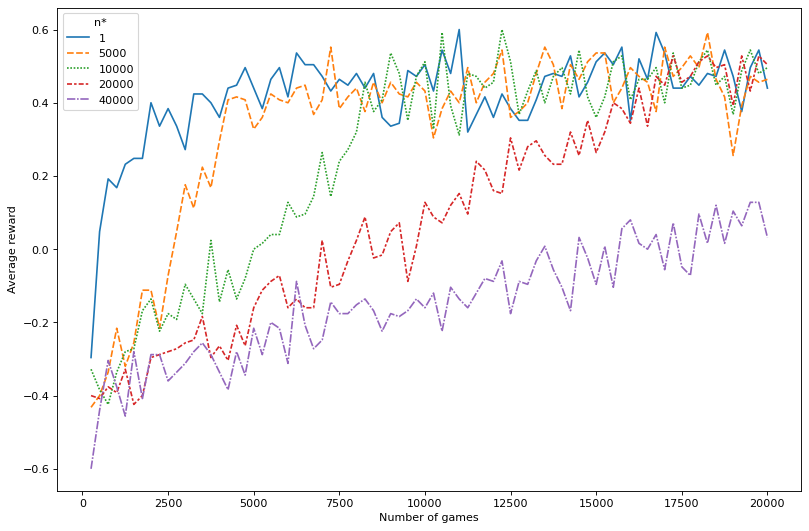

In [7]:
# Question 2
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=avg_rewardsDE)
ax.set(ylabel="Average reward")
plt.show()

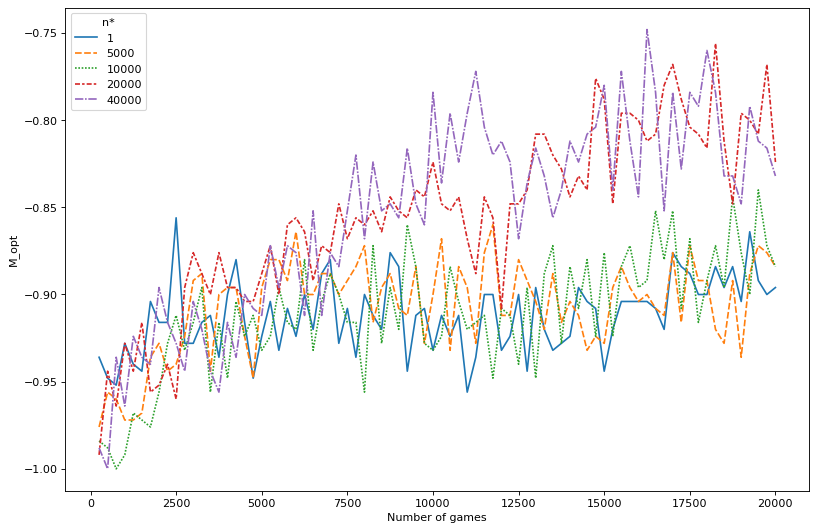

In [8]:
# Question 3
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_optsDE)
ax.set(ylabel="M_opt")
plt.show()

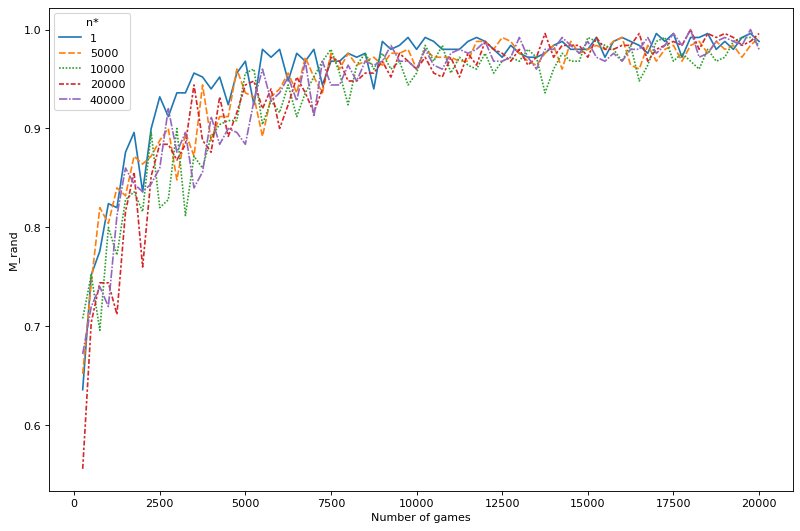

In [9]:
# Question 3
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_randsDE)
ax.set(ylabel="M_rand")
plt.show()

### vs. good and bad experts with n* = 20000

In [33]:
M_optsDE = pd.DataFrame(index=list(range(250, 20001, 250))).rename_axis("Number of games")
M_optsDE = M_optsDE.rename_axis("epsilon_opt", axis=1)

M_randsDE = pd.DataFrame(index=list(range(250, 20001, 250))).rename_axis("Number of games")
M_randsDE = M_randsDE.rename_axis("epsilon_opt", axis=1)

player_opt = OptimalPlayer(epsilon=0, player=1)
player_Q_DE0 = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE0, player_opt, 20000)
M_optsDE["0"] = M_opts
M_randsDE["0"] = M_rands

player_opt.epsilon = 0.2
player_Q_DE = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 20000)
M_optsDE["0.2"] = M_opts
M_randsDE["0.2"] = M_rands

player_opt.epsilon = 0.4
player_Q_DE = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 20000)
M_optsDE["0.4"] = M_opts
M_randsDE["0.4"] = M_rands

player_opt.epsilon = 0.6
player_Q_DE = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 20000)
M_optsDE["0.6"] = M_opts
M_randsDE["0.6"] = M_rands

player_opt.epsilon = 0.8
player_Q_DE = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE, player_opt, 20000)
M_optsDE["0.8"] = M_opts
M_randsDE["0.8"] = M_rands

player_opt.epsilon = 1
player_Q_DE1 = NimQlearningAgent(player=0)
avg_rewards, M_opts, M_rands = playGamesDecreasingExploration(env, player_Q_DE1, player_opt, 20000)
M_optsDE["1"] = M_opts
M_randsDE["1"] = M_rands

Winrate: 0.1351
Winrate: 0.34595
Winrate: 0.4813
Winrate: 0.5882
Winrate: 0.6877
Winrate: 0.7545


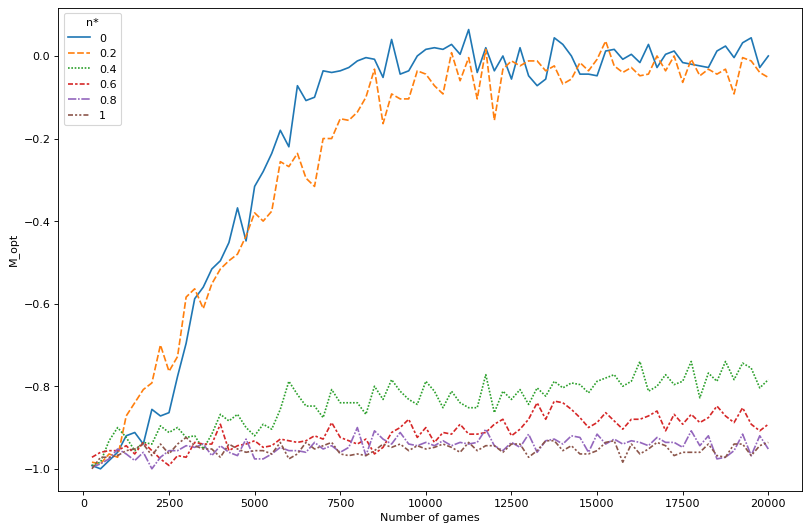

In [11]:
# Question 4
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_optsDE)
ax.set(ylabel="M_opt")
plt.show()

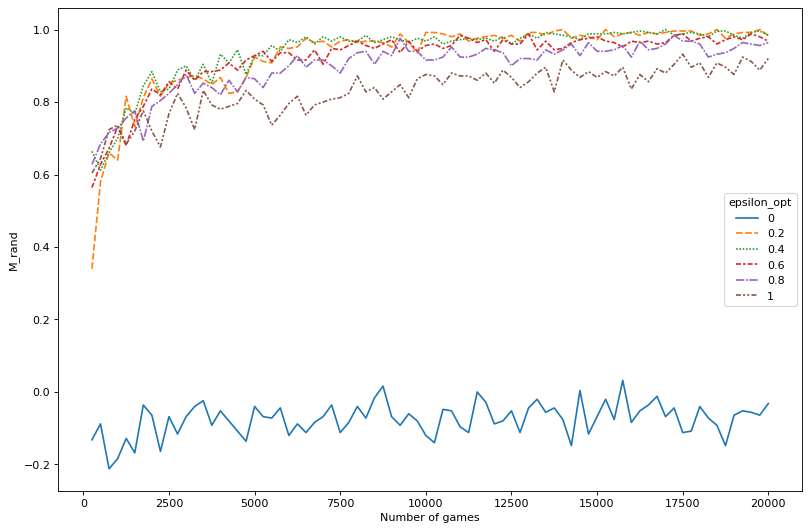

In [12]:
# Question 4
plt.figure(figsize=(12, 8), dpi=80)
ax = sns.lineplot(data=M_randsDE)
ax.set(ylabel="M_rand")
plt.show()

In [26]:
# Question 5
max_M_opt = M_optsDE.max().max()
argmax_epsilon_opt = M_optsDE.max().idxmax()
argmax_num_games = M_optsDE.max(axis=1).idxmax()
print(f"Highest M_opt value of {max_M_opt} achieved after {argmax_num_games} games while training against Opt({argmax_epsilon_opt})")

Highest M_opt value of 0.064 achieved after 11250 games while training against Opt(0)


In [32]:
max_M_rand = M_randsDE.max().max()
argmax_epsilon_opt = M_randsDE.max().idxmax()
argmax_num_games = M_randsDE.max(axis=1).idxmax()
print(f"Highest M_rand value of {max_M_rand} achieved after {argmax_num_games} games while training against Opt({argmax_epsilon_opt})")

Highest M_rand value of 1.0 achieved after 14000 games while training against Opt(0.2)


In nim, the first player has a winning strategy iff the nim-sum (bit-wise addition mod 2) of the heap-sizes is nonzero. Otherwise the second player has a winning strategy. So M_opt > 0 is possible by getting lucky in board generation.

Question 6: Q-values depend only on the state and the action taken in that state. How the agent got to the state (if it played against Opt(0) or Opt(1)) is irrelevant. The optimal Q-values do not depend on which opponent you are playing against. Q_1(s,a) should be found more quickly than Q_2(s,a), but their values are the same.